In [1]:
from autoencoder_utils import AutoEncoder, train_autoencoder
from sklearn.metrics import classification_report
import pandas as pd
from scoring_utils import purity_score, score_clustering, clustering_classification_report
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from clustering_utils import score_dbscan, score_kmeans, fit_dbscan, fit_kmeans, extract_kmeans_cluster_labels, test_dbscan
from plotting_utils import plot_2d_clusters

# Load and preprocess data

In [2]:
data = pd.read_csv('creditcard.csv')
X = data.drop(['Class', 'Amount', 'Time'], axis=1)
y = data['Class']

X_scale = MinMaxScaler().fit_transform(X)

# sample data to reduce class imbalance
non_fraud_df = X_scale[y == 0][:2000]
fraud_df = X_scale[y == 1]

X_sample = np.vstack([non_fraud_df, fraud_df])
fraud_idx = np.zeros(len(X_sample))
fraud_idx[-len(fraud_df):] = 1

indices = np.arange(len(X_sample))
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X_sample, fraud_idx, indices, test_size=0.2, random_state=42, stratify=fraud_idx)

# Clustering on raw data

## Kmeans

In [3]:
cluster_metrics, classification_metrics = score_kmeans(X_train, X_test, y_train, y_test)
results_df = pd.DataFrame(cluster_metrics)
reports_df = pd.DataFrame(classification_metrics)

print(results_df.round(2))
reports_df.round(2)

   n_clusters  Train_DB  Train_Sil  Train_Pur  Test_DB  Test_Sil  Test_Pur
0           2      0.84       0.63       0.56     0.79      0.64      0.60
1           3      1.09       0.48       0.79     1.05      0.47      0.81
2           5      1.97       0.12       0.77     1.93      0.13      0.79
3          10      1.96       0.11       0.82     1.74      0.12      0.83


,n_clusters,Train_Acc,Train_F1,Train_Recall,Train_Precision,Test_Acc,Test_F1,Test_Recall,Test_Precision
0,2,0.91,0.72,0.56,1.00,0.92,0.75,0.60,1.00
1,3,0.96,0.88,0.79,0.99,0.96,0.89,0.81,0.99
2,5,0.95,0.87,0.77,1.00,0.96,0.88,0.79,0.99
3,10,0.96,0.90,0.82,0.99,0.96,0.90,0.83,0.99


## DBSCAN

In [4]:
dbscan_cluster_metrics, dbscan_classification_metrics = score_dbscan(X_train, X_test, y_train, y_test)
dbscan_results_df = pd.DataFrame(dbscan_cluster_metrics)
dbscan_reports_df = pd.DataFrame(dbscan_classification_metrics)

print(dbscan_results_df.round(2))
dbscan_reports_df.round(2)

   eps  Train_DB  Train_Sil  Train_Pur  Test_DB  Test_Sil  Test_Pur
0  0.2      1.87       0.31       0.83     1.93      0.25      0.82
1  0.3      1.31       0.61       0.23     1.16      0.61      0.28
2  0.4      0.90       0.57       0.02     0.30      0.55      0.02


,eps,Train_Acc,Train_F1,Train_Recall,Train_Precision,Test_Acc,Test_F1,Test_Recall,Test_Precision
0,0.2,0.96,0.89,0.84,0.94,0.95,0.86,0.85,0.88
1,0.3,0.85,0.38,0.23,0.97,0.86,0.44,0.28,0.97
2,0.4,0.81,0.04,0.02,0.89,0.81,0.04,0.02,1.00


# Clustering on dimensionality reduced data

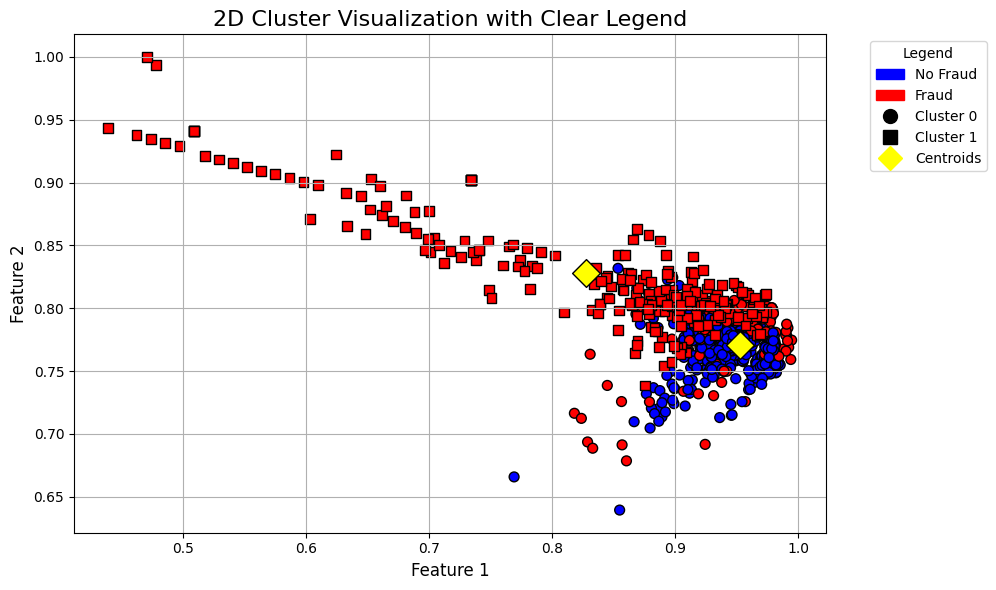

In [5]:


kmeans = fit_kmeans(X_train, 2)
train_cluster_labels = extract_kmeans_cluster_labels(kmeans, X_train)

kmeans_centroids = kmeans.cluster_centers_

# Here the clusters are fitted in all dimensions but only first two are plotted
plot_2d_clusters(X_train, y_train, train_cluster_labels, kmeans_centroids)

## PCA



In [6]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_full_pca = pca.transform(X_scale)

### Kmeans

In [7]:
# find the optimal number of clusters
pca_clustering, pca_classification = score_kmeans(X_train_pca, X_test_pca, y_train, y_test)
pca_clustering_df = pd.DataFrame(pca_clustering)
pca_classification_df = pd.DataFrame(pca_classification)

print(pca_clustering_df.round(2))
pca_classification_df.round(2)

   n_clusters  Train_DB  Train_Sil  Train_Pur  Test_DB  Test_Sil  Test_Pur
0           2      0.51       0.81       0.56     0.49      0.82      0.60
1           3      0.63       0.78       0.79     0.54      0.78      0.81
2           5      0.83       0.42       0.79     0.78      0.43      0.81
3          10      0.74       0.43       0.86     0.78      0.42      0.89


,n_clusters,Train_Acc,Train_F1,Train_Recall,Train_Precision,Test_Acc,Test_F1,Test_Recall,Test_Precision
0,2,0.91,0.72,0.56,1.00,0.92,0.75,0.60,1.00
1,3,0.96,0.88,0.79,0.99,0.96,0.89,0.81,0.99
2,5,0.96,0.88,0.79,0.99,0.96,0.89,0.81,0.99
3,10,0.97,0.91,0.87,0.95,0.97,0.92,0.90,0.95


   accuracy    f1  recall  precision
0       1.0  0.79    0.79       0.79


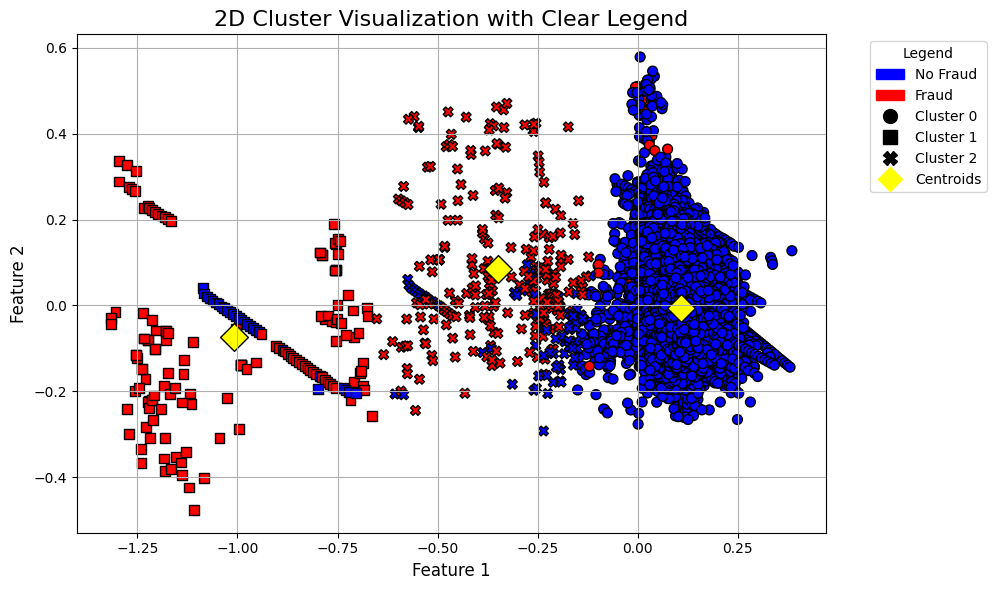

In [8]:
# test on full data
k = 3 # selected from the previous analysis
kmeans = fit_kmeans(X_train_pca, k)
full_cluster_labels = extract_kmeans_cluster_labels(kmeans, X_full_pca)
full_kmeans_centroids = kmeans.cluster_centers_

print(pd.DataFrame(clustering_classification_report(full_cluster_labels, y, use_class_fraction=False), index=[0]).round(2))

plot_2d_clusters(X_full_pca, y, full_cluster_labels, full_kmeans_centroids)

### DBSCAN

In [9]:
# find the optimal number of clusters
eps = np.arange(0.05, 0.1, 0.005)
pca_clustering, pca_classification = score_dbscan(X_train_pca, X_test_pca, y_train, y_test, eps)
pca_clustering_df = pd.DataFrame(pca_clustering)
pca_classification_df = pd.DataFrame(pca_classification)

print(pca_clustering_df.round(3))
pca_classification_df.round(2)

     eps  Train_DB  Train_Sil  Train_Pur  Test_DB  Test_Sil  Test_Pur
0  0.050     1.650      0.715      0.823    2.043     0.702     0.836
1  0.055     1.643      0.721      0.821    2.396     0.700     0.836
2  0.060     1.617      0.715      0.813    2.428     0.708     0.826
3  0.065     1.724      0.720      0.810    1.632     0.716     0.826
4  0.070     1.268      0.746      0.810    0.819     0.727     0.826
5  0.075     1.353      0.766      0.795    0.922     0.763     0.816
6  0.080     1.396      0.766      0.795    0.922     0.763     0.816
7  0.085     0.700      0.677      0.150    0.362     0.767     0.212
8  0.090     0.620      0.539      0.150    0.362     0.767     0.212
9  0.095     0.540      0.373      0.148    0.362     0.767     0.212


,eps,Train_Acc,Train_F1,Train_Recall,Train_Precision,Test_Acc,Test_F1,Test_Recall,Test_Precision
0,0.05,0.96,0.90,0.82,0.99,0.97,0.91,0.84,0.99
1,0.06,0.96,0.90,0.82,0.99,0.97,0.91,0.84,0.99
2,0.06,0.96,0.90,0.81,0.99,0.96,0.90,0.83,0.99
3,0.06,0.96,0.89,0.81,0.99,0.96,0.90,0.83,0.99
4,0.07,0.96,0.89,0.81,0.99,0.96,0.90,0.83,0.99
5,0.07,0.96,0.88,0.80,0.99,0.96,0.90,0.82,0.99
6,0.08,0.96,0.88,0.80,0.99,0.96,0.90,0.82,0.99
7,0.08,0.83,0.26,0.15,1.00,0.84,0.35,0.21,1.00
8,0.09,0.83,0.26,0.15,1.00,0.84,0.35,0.21,1.00
9,0.09,0.83,0.26,0.15,1.00,0.84,0.35,0.21,1.00


   accuracy    f1  recall  precision
0       1.0  0.75    0.76       0.75


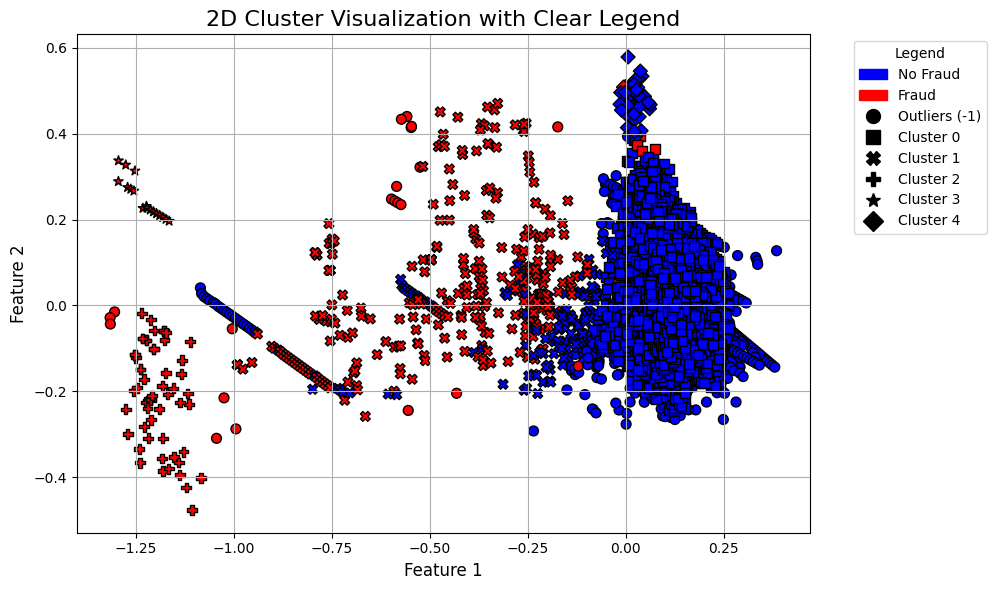

In [10]:
eps = 0.07
dbscan = fit_dbscan(X_train_pca, eps)

full_cluster_labels = test_dbscan(dbscan, X_train_pca, X_full_pca)

print(pd.DataFrame(clustering_classification_report(full_cluster_labels, y, use_class_fraction=False), index=[0]).round(2))

plot_2d_clusters(X_full_pca, y, full_cluster_labels)


## AutoEncoder

In [16]:
BATCH_SIZE = 256
EPOCHS = 1000
LEARNING_RATE = 1e-3
ac = AutoEncoder(latent_dim=2)

train_autoencoder(ac, X_train, X_test, EPOCHS, BATCH_SIZE, LEARNING_RATE)

X_train_ac = ac.encode_numpy(X_train)
X_test_ac = ac.encode_numpy(X_test)
X_full_ac = ac.encode_numpy(X_scale)


Epoch 1/1000, Train Loss: 0.2846, Val Loss: 0.2140
Epoch 11/1000, Train Loss: 0.0049, Val Loss: 0.0054
Epoch 21/1000, Train Loss: 0.0039, Val Loss: 0.0042
Epoch 31/1000, Train Loss: 0.0020, Val Loss: 0.0020
Epoch 41/1000, Train Loss: 0.0019, Val Loss: 0.0019
Epoch 51/1000, Train Loss: 0.0019, Val Loss: 0.0019
Epoch 61/1000, Train Loss: 0.0018, Val Loss: 0.0018
Epoch 71/1000, Train Loss: 0.0018, Val Loss: 0.0018
Epoch 81/1000, Train Loss: 0.0017, Val Loss: 0.0017
Epoch 91/1000, Train Loss: 0.0016, Val Loss: 0.0016
Epoch 101/1000, Train Loss: 0.0016, Val Loss: 0.0016
Epoch 111/1000, Train Loss: 0.0015, Val Loss: 0.0016
Epoch 121/1000, Train Loss: 0.0015, Val Loss: 0.0015
Epoch 131/1000, Train Loss: 0.0015, Val Loss: 0.0015
Epoch 141/1000, Train Loss: 0.0015, Val Loss: 0.0015
Epoch 151/1000, Train Loss: 0.0014, Val Loss: 0.0015
Epoch 161/1000, Train Loss: 0.0014, Val Loss: 0.0015
Epoch 171/1000, Train Loss: 0.0014, Val Loss: 0.0015
Epoch 181/1000, Train Loss: 0.0014, Val Loss: 0.0014
Epoc

### Kmeans

In [17]:
pca_clustering, pca_classification = score_kmeans(X_train_ac, X_test_ac, y_train, y_test)
pca_clustering_df = pd.DataFrame(pca_clustering)
pca_classification_df = pd.DataFrame(pca_classification)

print(pca_clustering_df.round(2))
pca_classification_df.round(2)

   n_clusters  Train_DB  Train_Sil  Train_Pur  Test_DB  Test_Sil  Test_Pur
0           2      0.47       0.82       0.46     0.45      0.83      0.52
1           3      0.51       0.76       0.75     0.49      0.77      0.77
2           5      0.77       0.45       0.77     0.73      0.46      0.80
3          10      0.83       0.36       0.78     0.79      0.37      0.81


,n_clusters,Train_Acc,Train_F1,Train_Recall,Train_Precision,Test_Acc,Test_F1,Test_Recall,Test_Precision
0,2,0.89,0.63,0.46,1.00,0.90,0.68,0.52,1.00
1,3,0.95,0.86,0.75,0.99,0.95,0.86,0.77,0.99
2,5,0.95,0.87,0.77,0.99,0.96,0.88,0.80,0.99
3,10,0.96,0.88,0.78,0.99,0.96,0.89,0.81,0.99


   accuracy    f1  recall  precision
0       1.0  0.78    0.75       0.82


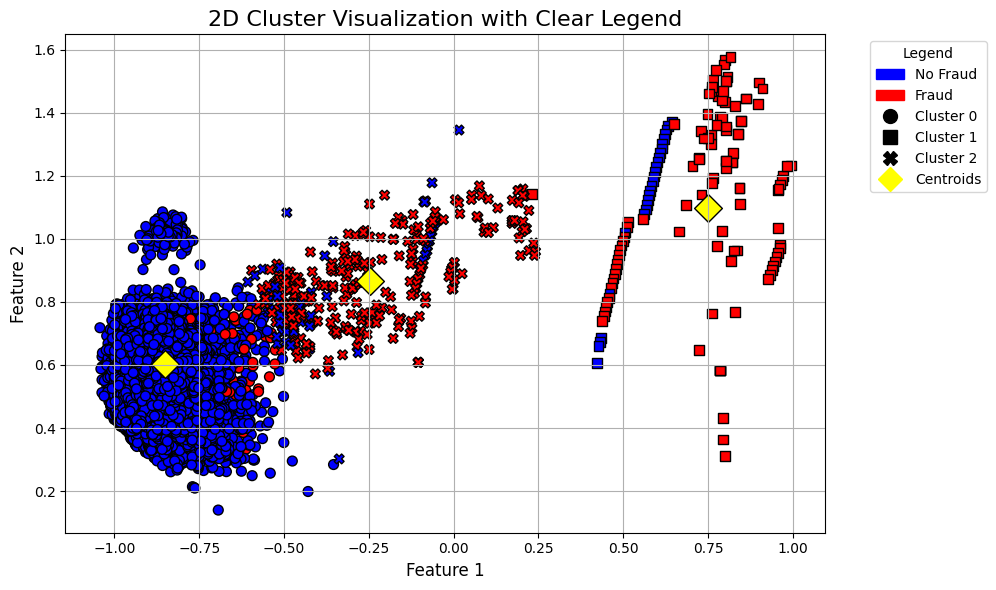

In [18]:
# test on full data
k = 3 # selected from the previous analysis
kmeans = fit_kmeans(X_train_ac, k)
full_cluster_labels = extract_kmeans_cluster_labels(kmeans, X_full_ac)
full_kmeans_centroids = kmeans.cluster_centers_

print(pd.DataFrame(clustering_classification_report(full_cluster_labels, y, use_class_fraction=False), index=[0]).round(2))

plot_2d_clusters(X_full_ac, y, full_cluster_labels, full_kmeans_centroids)

### DBSCAN

In [14]:
# find the optimal number of clusters
eps = np.arange(0.05, 0.1, 0.005)
pca_clustering, pca_classification = score_dbscan(X_train_ac, X_test_ac, y_train, y_test, eps)
pca_clustering_df = pd.DataFrame(pca_clustering)
pca_classification_df = pd.DataFrame(pca_classification)

print(pca_clustering_df.round(3))
pca_classification_df.round(2)

     eps  Train_DB  Train_Sil  Train_Pur  Test_DB  Test_Sil  Test_Pur
0  0.050     1.360     -0.373      0.528    1.265    -0.371     0.472
1  0.055     1.158     -0.272      0.595    1.234    -0.286     0.543
2  0.060     1.084     -0.151      0.757    1.222    -0.198     0.739
3  0.065     1.061     -0.123      0.790    1.235    -0.153     0.784
4  0.070     1.746     -0.135      0.801    1.281    -0.133     0.822
5  0.075     1.620      0.100      0.809    1.282     0.256     0.857
6  0.080     1.499      0.060      0.819    1.350     0.078     0.854
7  0.085     1.467      0.111      0.826    1.583     0.217     0.846
8  0.090     1.337      0.274      0.828    1.647     0.227     0.851
9  0.095     1.232      0.418      0.824    1.469     0.352     0.834


,eps,Train_Acc,Train_F1,Train_Recall,Train_Precision,Test_Acc,Test_F1,Test_Recall,Test_Precision
0,0.05,0.82,0.18,0.10,0.95,0.81,0.08,0.04,1.00
1,0.06,0.82,0.17,0.09,1.00,0.81,0.10,0.05,1.00
2,0.06,0.85,0.71,0.93,0.57,0.83,0.68,0.94,0.54
3,0.06,0.88,0.76,0.91,0.64,0.86,0.73,0.94,0.60
4,0.07,0.90,0.79,0.89,0.70,0.90,0.79,0.93,0.68
5,0.07,0.92,0.81,0.88,0.75,0.93,0.84,0.93,0.76
6,0.08,0.93,0.83,0.88,0.79,0.94,0.85,0.91,0.80
7,0.08,0.94,0.85,0.87,0.84,0.94,0.86,0.89,0.84
8,0.09,0.95,0.86,0.86,0.87,0.95,0.87,0.89,0.85
9,0.09,0.95,0.87,0.85,0.90,0.95,0.86,0.87,0.86


   accuracy    f1  recall  precision
0       1.0  0.25    0.14        0.9


/var/folders/d5/9pr42pvx4gjc3y30qdktwz900000gn/T/ipykernel_18766/3470201811.py:23: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


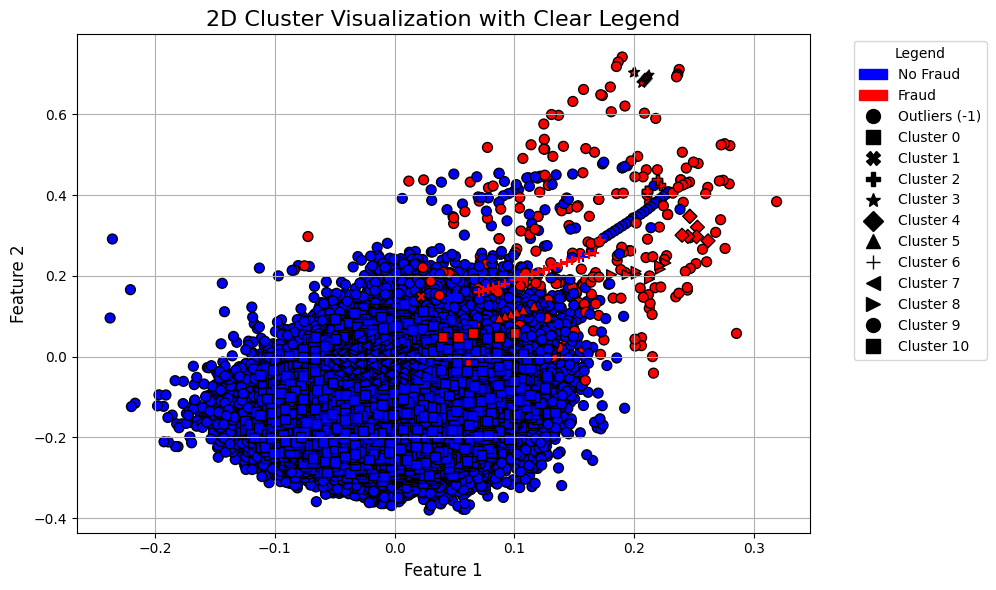

In [15]:
eps = 0.075
dbscan = fit_dbscan(X_train_ac, eps)

full_cluster_labels = test_dbscan(dbscan, X_train_ac, X_full_ac)

print(pd.DataFrame(clustering_classification_report(full_cluster_labels, y, use_class_fraction=False), index=[0]).round(2))

plot_2d_clusters(X_full_ac, y, full_cluster_labels)